In [121]:
# import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import sklearn
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
#
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures()
#
import os
import numpy as np
import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
#
from sklearn.preprocessing import LabelEncoder
make_lb = LabelEncoder()
#
from sklearn.preprocessing import LabelBinarizer
lbb = LabelBinarizer()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

# Data Cleaning & Exploration

In [2]:
df = pd.read_csv('student_data.csv')

In [3]:
df.rename(columns={'default payment next month': 'default'}, inplace=True)
df.columns=df.columns.str.lower()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23999 entries, 0 to 23998
Data columns (total 25 columns):
id           23999 non-null int64
limit_bal    23999 non-null int64
sex          23999 non-null int64
education    23999 non-null int64
marriage     23999 non-null int64
age          23999 non-null int64
pay_0        23999 non-null int64
pay_2        23999 non-null int64
pay_3        23999 non-null int64
pay_4        23999 non-null int64
pay_5        23999 non-null int64
pay_6        23999 non-null int64
bill_amt1    23999 non-null int64
bill_amt2    23999 non-null int64
bill_amt3    23999 non-null int64
bill_amt4    23999 non-null int64
bill_amt5    23999 non-null int64
bill_amt6    23999 non-null int64
pay_amt1     23999 non-null int64
pay_amt2     23999 non-null int64
pay_amt3     23999 non-null int64
pay_amt4     23999 non-null int64
pay_amt5     23999 non-null int64
pay_amt6     23999 non-null int64
default      23999 non-null int64
dtypes: int64(25)
memory usage: 4.6 MB


#### For Reference

X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
X2: Gender (1 = male; 2 = female).
X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
X4: Marital status (1 = married; 2 = single; 3 = others).
X5: Age (year).
X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.  

Found this to only be slightly helpful. Not so much cleaning but more wrangling will be involved.

In [5]:
df['default'].value_counts()

0    18691
1     5308
Name: default, dtype: int64

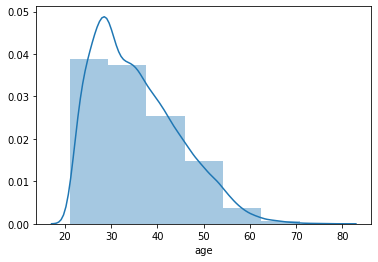

In [6]:
# Viewing the distribution of age in the data
sns.distplot(df['age'], bins = 7)

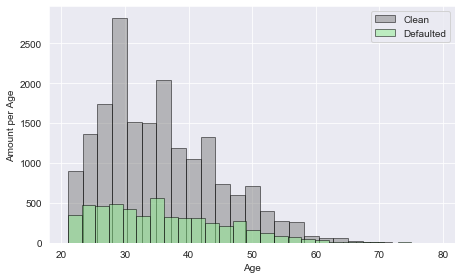

In [7]:
# Plotting total number 'clean' with the total number 'defaulted' over it
# There is a bit of a misalignment with the distribution
# Ages should be binned
sns.set_style('darkgrid')
fig = plt.figure(figsize = (16,10))
fig.subplots_adjust(hspace = .30)

ax1 = fig.add_subplot(221)
ax1.hist(df[df['default'] ==0].age, bins = 25, label ='Clean', alpha = .50,edgecolor= 'black',color ='grey')
ax1.hist(df[df['default']==1].age, bins = 25, label = 'Defaulted', alpha = .50, edgecolor = 'black',color = 'lightgreen')
ax1.set_xlabel('Age')
ax1.set_ylabel('Amount per Age')
ax1.legend(loc = 'upper right')

A bit wonky but still gives a good idea of how the `default` classification is spread out throughout age groups. Those between 20-40 make up most of this data.

In [8]:
# Making sex a binary term
# Dropping the `sex` column and replacing with gender
gender = []
for x in df['sex']:
    if x == 1:
        gender.append(1)
    elif x == 2:
        gender.append(0)

df['gender'] = gender
df.drop(columns=['sex'], axis=1, inplace=True)

In [9]:
# Since I don't know what is above 4 in regards to education, I am going to bin 
# All of the education types into their labeled types, except all above 4 are `others`
# Making dummies for the different education levels

df['edu'] = pd.cut(df['education'], 4, labels=['grad', 'undergrad', 'highschool', 'others'])
df[['edu', 'education']]
dums = pd.get_dummies(df['edu'], drop_first=True)
df.drop(columns=['education'], axis=1, inplace=True)

In [10]:
# Adding the dummies, dropping the old column
df = df.join(dums)
df.drop(columns=['edu'], axis=1, inplace=True)

In [11]:
df.drop(columns=['marriage', 'id',], axis=1, inplace=True)

In [12]:
# # Manually MinMax scaling the continuous columns
# # Normalization

# col_to_norm = ['limit_bal', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6',
#               'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']
# df[col_to_norm] = df[col_to_norm].apply(lambda x: (x - x.min()) /(x.max() - x.min()), axis=0)

Bit of a divergence here. I want to see what happens if I just make the `pay_x` columns either 0 or 1. 0 for not late/on time, 1 for late. Not sure if this will help or hurt, which is why I am going to diverge a separate data frame for that.

In [13]:
df.loc[df.pay_0 <= 0, 'pay_0'] = 0
df.loc[df.pay_0 > 0, 'pay_0'] = 1
df.loc[df.pay_2 <= 0, 'pay_2'] = 0
df.loc[df.pay_2 > 0, 'pay_2'] = 1
df.loc[df.pay_3 <= 0, 'pay_3'] = 0
df.loc[df.pay_3 > 0, 'pay_3'] = 1
df.loc[df.pay_4 <= 0, 'pay_4'] = 0
df.loc[df.pay_4 > 0, 'pay_4'] = 1
df.loc[df.pay_5 <= 0, 'pay_5'] = 0
df.loc[df.pay_5 > 0, 'pay_5'] = 1
df.loc[df.pay_6 <= 0, 'pay_6'] = 0
df.loc[df.pay_6 > 0, 'pay_6'] = 1

In [14]:
# # Adding a new column that might be useful
# # Is a continuous column that is the addition or total number of times
# # Individual was late on payment over the past 6 months
# # Experimental feature
# df2['pay_sum'] = df2.apply(lambda row: row.pay_0 + row.pay_2 + row.pay_3 + row.pay_4 + row.pay_5 + row.pay_6, axis=1)

# # View to see
# df2.head()
# df2.groupby('default')['pay_sum'].value_counts()

Here is a good question: `Is the proportion of those who defaulted having multiple late payments higher than that of those who did not default?`  
  

Another good question: `Is the proportion of those who defaulted having zero late payments lower than that of those who did not default?`

In [15]:
df.head()

,limit_bal,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default,gender,undergrad,highschool,others
0,350000,37,0,0,0,0,0,0,316,316,316,466,466,316,316,316,466,466,316,316,0,1,0,0,0
1,50000,37,1,1,1,0,0,0,40994,43594,38222,13026,13268,13497,5500,0,580,600,600,600,0,0,1,0,0
2,50000,23,0,0,0,0,0,0,3430,2478,2299,4800,9810,660,2548,2321,4800,9810,660,2980,0,0,0,0,0
3,20000,56,0,0,0,0,1,0,10847,12176,12884,13784,13420,13686,1508,1216,1116,0,490,658,0,1,1,0,0
4,110000,32,0,0,0,0,0,0,108159,106812,108464,108829,110557,106082,5400,5400,4100,4100,4100,4200,0,0,1,0,0


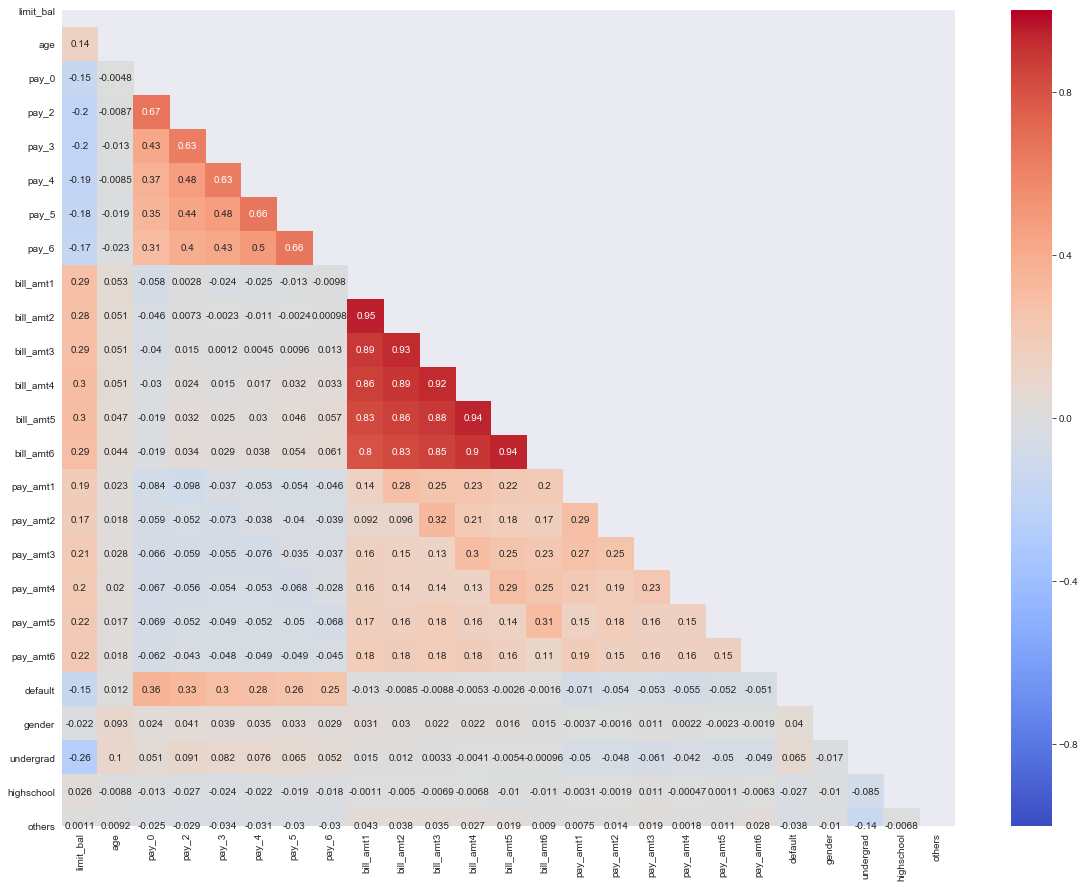

In [16]:
f, ax = plt.subplots(figsize=(20, 15))
matrix = np.triu(df.corr())
sns.heatmap(df.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask = matrix)

---

# Model Creation

In [84]:
# All features, including ones I was going to drop
X = df.drop(columns=['default'], axis=1)
y = df.default
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, test_size=0.25)


In [85]:
col_to_norm = ['limit_bal', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6',
              'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']
X_train[col_to_norm] = X_train[col_to_norm].apply(lambda x: (x - x.min()) /(x.max() - x.min()), axis=0)
X_test[col_to_norm] = X_test[col_to_norm].apply(lambda x: (x - x.min()) /(x.max() - x.min()), axis=0)

In [86]:
# Fitting a baseline LogReg model
logreg = LogisticRegression(C=1e14, solver='lbfgs', fit_intercept=False)
model_1 = logreg.fit(X_train, y_train)
# allfeats_coef = dict(zip(list(X_train.columns), list(model_1_allfeats.coef_[0])))

In [87]:
y_train_pred = model_1.predict(X_train)
y_test_pred = model_1.predict(X_test)

In [88]:
train_report = classification_report(y_train, y_train_pred)
test_report = classification_report(y_test, y_test_pred)

In [89]:
print(test_report)

              precision    recall  f1-score   support

           0       0.81      0.96      0.88      4657
           1       0.63      0.24      0.34      1343

    accuracy                           0.80      6000
   macro avg       0.72      0.60      0.61      6000
weighted avg       0.77      0.80      0.76      6000



In [90]:
y_test_scores = model_1.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_test_scores)
auc(fpr, tpr)

0.738571835830768

In [91]:
y_pred_prob = model_1.predict_proba(X_test)[:, 1]

Text(0, 0.5, 'Frequency')

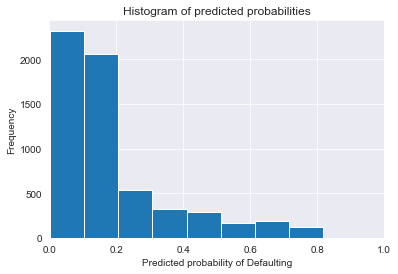

In [92]:
plt.hist(y_pred_prob, bins=8)
plt.xlim(0, 1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of Defaulting')
plt.ylabel('Frequency')

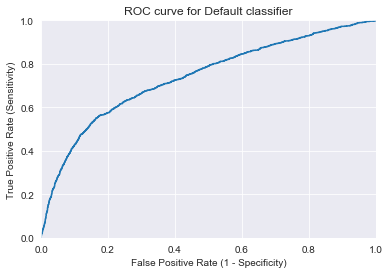

In [93]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Default classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [94]:
from sklearn.model_selection import cross_val_score
cross_val_score(model_1, X_train, y_train, cv=10, scoring='roc_auc').mean()

0.735115302217329

In [104]:
model_1.score(X_test, y_test)

0.7976666666666666

---

In [95]:
from sklearn.model_selection import GridSearchCV

In [96]:
logreg = LogisticRegression()
penalty = ['l1', 'l2']
C = np.logspace(0,4,10)
hyperparameters = dict(C=C, penalty=penalty)

In [97]:
clf = GridSearchCV(logreg, hyperparameters, cv=5)

In [98]:
X2 = X[col_to_norm].apply(lambda x: (x - x.min()) /(x.max() - x.min()), axis=0)

In [99]:
best_model = clf.fit(X2, y)

In [1]:
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

NameError: name 'best_model' is not defined

In [101]:
# Using the best parameters from the gridsearch
logreg_2 = LogisticRegression(penalty='l1', fit_intercept=False,
                             random_state=42, max_iter=1000)
model_2 = logreg_2.fit(X_train, y_train)
y_pred_prob2 = model_2.predict_proba(X_test)[:, 1]

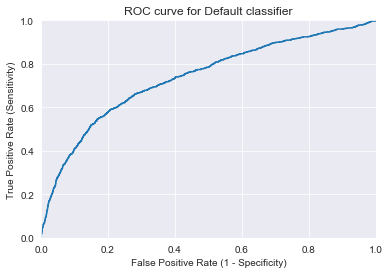

In [102]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob2)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Default classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [103]:
model_2.score(X_test, y_test)

0.7835

---

Going to look into `LogRegCV`


In [26]:
from sklearn.linear_model import LogisticRegressionCV


In [27]:
lgcv = LogisticRegressionCV(fit_intercept=False, penalty='l1',
                           random_state=42, solver= 'liblinear', cv=10)

In [65]:
cv_model = lgcv.fit(X2, y)
print(cv_model.predict(X2))
print(cv_model.score(X2, y))


[0 0 0 ... 0 0 0]
0.7788241176715697


---

I want to eliminate more multicollinearity by removing some of the repetitive predictors.

In [19]:
X = df.drop(columns=['bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6',], axis=1)
y = df.default

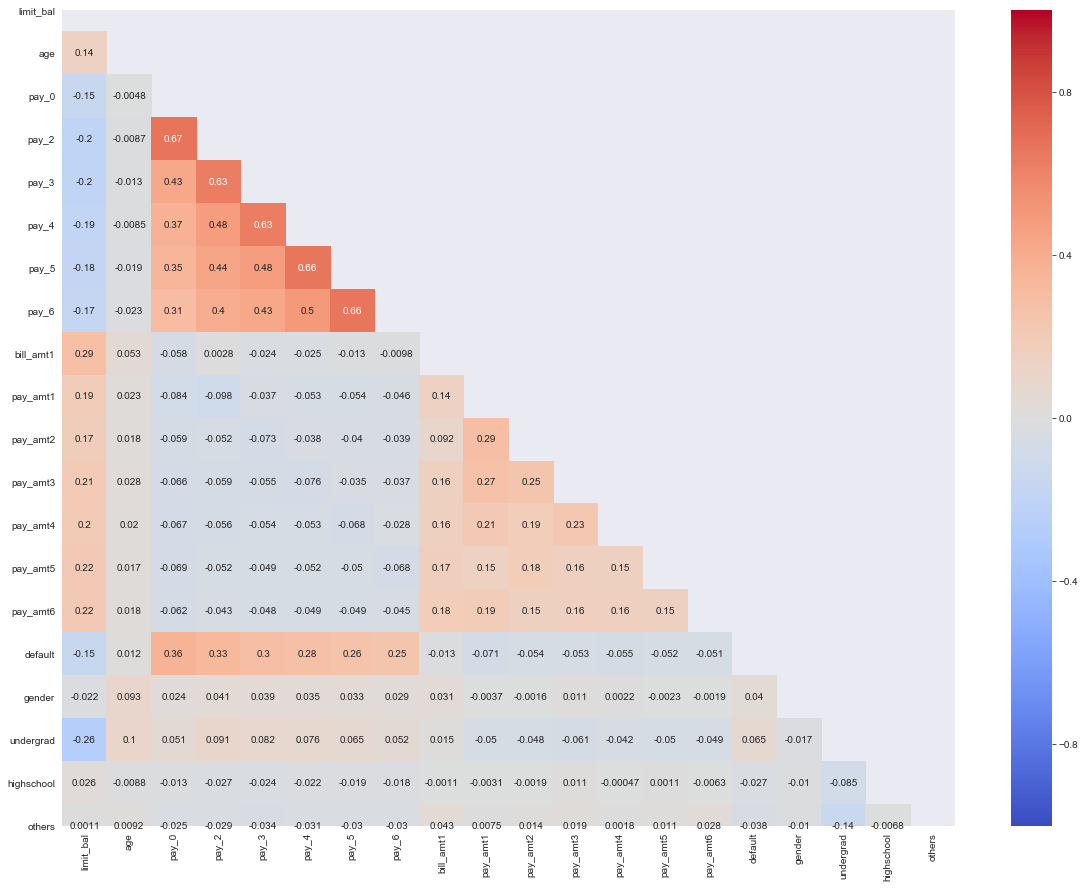

In [20]:
f, ax = plt.subplots(figsize=(20, 15))
matrix = np.triu(X.corr())
sns.heatmap(X.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask = matrix)

I want to try to make a pay_x sum column and see how the model does

In [23]:
X_new = X.iloc[:, 2:8]

In [24]:
X_new

,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6
0,0,0,0,0,0,0
1,1,1,1,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,1,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
23994,0,0,0,0,0,0
23995,0,0,0,0,0,0
23996,1,0,0,1,1,1
23997,0,0,0,0,0,0


In [28]:
cv_model2 = lgcv.fit(X_new, y)
print(cv_model2.predict(X_new))
print(cv_model2.score(X_new, y))

[0 1 0 ... 0 0 1]
0.7951997999916663


In [29]:
y_pred_prob3 = cv_model2.predict_proba(X_new)[:, 1]

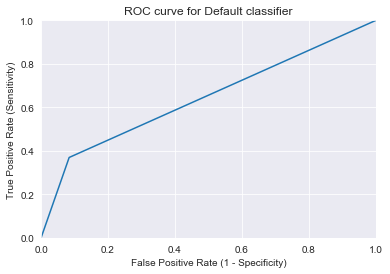

In [30]:
fpr, tpr, thresholds = roc_curve(y, y_pred_prob3)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Default classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

---

In [122]:
with open('df_trimmed.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    df_final = pickle.load(f)
df_final.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,default payment next month,avg_utilization,avg_payment_impact,debt_streak,debt_avg_delta,payment_improvements,PAY_0N1,PAY_0N2
0,2873.0,350000.0,1.0,1.0,2.0,37.0,0,0.0,0.001046,0.001046,0.0,0.000000,0.0,0,0
1,3598.0,50000.0,2.0,2.0,1.0,37.0,2,0.0,0.542003,0.026267,0.0,0.000000,0.0,0,0
2,27623.0,50000.0,2.0,1.0,2.0,23.0,0,0.0,0.078257,0.077063,2.0,0.011310,0.0,1,1
3,6874.0,20000.0,1.0,3.0,1.0,56.0,0,0.0,0.639975,0.041567,0.0,0.000000,1.0,0,0
4,6444.0,110000.0,2.0,2.0,2.0,32.0,0,0.0,0.983186,0.041364,1.0,0.012245,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23994,7886.0,50000.0,2.0,1.0,2.0,24.0,0,1.0,0.087653,0.025073,0.0,0.000000,0.0,0,0
23995,7750.0,250000.0,1.0,3.0,1.0,44.0,0,1.0,0.064921,0.062142,1.0,0.011704,0.0,1,1
23996,14379.0,50000.0,1.0,3.0,2.0,26.0,2,1.0,0.905577,0.037667,0.0,0.000000,0.0,0,0
23997,23664.0,110000.0,2.0,2.0,1.0,38.0,0,1.0,0.731603,0.172736,5.0,0.357682,0.0,0,0


In [123]:
df_final.drop(columns=['ID'], axis=1, inplace=True)

In [124]:
df_final

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,default payment next month,avg_utilization,avg_payment_impact,debt_streak,debt_avg_delta,payment_improvements,PAY_0N1,PAY_0N2
0,350000.0,1.0,1.0,2.0,37.0,0,0.0,0.001046,0.001046,0.0,0.000000,0.0,0,0
1,50000.0,2.0,2.0,1.0,37.0,2,0.0,0.542003,0.026267,0.0,0.000000,0.0,0,0
2,50000.0,2.0,1.0,2.0,23.0,0,0.0,0.078257,0.077063,2.0,0.011310,0.0,1,1
3,20000.0,1.0,3.0,1.0,56.0,0,0.0,0.639975,0.041567,0.0,0.000000,1.0,0,0
4,110000.0,2.0,2.0,2.0,32.0,0,0.0,0.983186,0.041364,1.0,0.012245,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23994,50000.0,2.0,1.0,2.0,24.0,0,1.0,0.087653,0.025073,0.0,0.000000,0.0,0,0
23995,250000.0,1.0,3.0,1.0,44.0,0,1.0,0.064921,0.062142,1.0,0.011704,0.0,1,1
23996,50000.0,1.0,3.0,2.0,26.0,2,1.0,0.905577,0.037667,0.0,0.000000,0.0,0,0
23997,110000.0,2.0,2.0,1.0,38.0,0,1.0,0.731603,0.172736,5.0,0.357682,0.0,0,0


In [125]:
from sklearn.feature_selection import RFECV

### General Layout

`rfecv = RFECV(estimator=MODEL, step=1, cv=,
              scoring='accuracy')`

In [126]:
df_final.rename(columns={'default payment next month':'default'}, inplace=True)
df_final.columns=df_final.columns.str.lower()
df_final.head()

,limit_bal,sex,education,marriage,age,pay_0,default,avg_utilization,avg_payment_impact,debt_streak,debt_avg_delta,payment_improvements,pay_0n1,pay_0n2
0,350000.0,1.0,1.0,2.0,37.0,0,0.0,0.001046,0.001046,0.0,0.000000,0.0,0,0
1,50000.0,2.0,2.0,1.0,37.0,2,0.0,0.542003,0.026267,0.0,0.000000,0.0,0,0
2,50000.0,2.0,1.0,2.0,23.0,0,0.0,0.078257,0.077063,2.0,0.011310,0.0,1,1
3,20000.0,1.0,3.0,1.0,56.0,0,0.0,0.639975,0.041567,0.0,0.000000,1.0,0,0
4,110000.0,2.0,2.0,2.0,32.0,0,0.0,0.983186,0.041364,1.0,0.012245,0.0,0,0


### I have to run my three base models with this data in order to see how it performs once I start to use a feature elimination module.

---

### Baseline Logistic Regression Model

In [127]:
# Preparing data for the model
df_fin_mms = df_final
df_fin_mms = minmax.fit_transform(df_fin_mms)

In [128]:
df_fin_mms = pd.DataFrame(df_fin_mms, columns=df_final.columns)

In [129]:
df_fin_mms.head()

,limit_bal,sex,education,marriage,age,pay_0,default,avg_utilization,avg_payment_impact,debt_streak,debt_avg_delta,payment_improvements,pay_0n1,pay_0n2
0,0.343434,0.0,0.166667,0.666667,0.275862,0.00,0.0,0.036158,0.000431,0.0,0.000000,0.0,0.0,0.0
1,0.040404,1.0,0.333333,0.333333,0.275862,0.25,0.0,0.133375,0.010819,0.0,0.000000,0.0,0.0,0.0
2,0.040404,1.0,0.166667,0.666667,0.034483,0.00,0.0,0.050034,0.031743,0.4,0.004299,0.0,1.0,1.0
3,0.010101,0.0,0.500000,0.333333,0.603448,0.00,0.0,0.150981,0.017122,0.0,0.000000,0.2,0.0,0.0
4,0.101010,1.0,0.333333,0.666667,0.189655,0.00,0.0,0.212660,0.017038,0.2,0.004655,0.0,0.0,0.0


In [130]:
y = df_fin_mms['default']
X = df_fin_mms.drop(columns=['default'], axis=1)

In [131]:
logreg_base = LogisticRegressionCV(random_state=42, cv=5, scoring = 'accuracy')
base_lr = logreg_base.fit(X, y)

In [132]:
# Uses 'accuracy' as the score
print('Accuracy:',base_lr.score(X, y))

Accuracy: 0.8197008208675362


In [133]:
pred = base_lr.predict(X)
print(classification_report(y, pred))

              precision    recall  f1-score   support

         0.0       0.84      0.95      0.89     18691
         1.0       0.68      0.35      0.46      5308

    accuracy                           0.82     23999
   macro avg       0.76      0.65      0.68     23999
weighted avg       0.80      0.82      0.80     23999



---

### Baseline KNN Model

In [134]:
knn = KNeighborsClassifier()

In [135]:
cross_validate(knn, X, y, scoring=['f1', 'recall', 'precision', 'accuracy'], cv=5)

{'fit_time': array([0.11206293, 0.07339215, 0.07381392, 0.13316584, 0.07029819]),
 'score_time': array([1.59735608, 1.50456095, 1.51800919, 1.61929798, 1.79064989]),
 'test_f1': array([0.41520468, 0.42747188, 0.41743119, 0.41852286, 0.43367935]),
 'test_recall': array([0.33427495, 0.33992467, 0.34274953, 0.33647502, 0.35438266]),
 'test_precision': array([0.54783951, 0.57575758, 0.53372434, 0.55348837, 0.55869242]),
 'test_accuracy': array([0.79171006, 0.79854167, 0.78833333, 0.79329027, 0.79537404])}

In [136]:
# Probably a better way of doing this
test_f1 = np.mean([0.41520468, 0.42747188, 0.41743119, 0.41852286, 0.43367935])
test_recall = np.mean([0.33427495, 0.33992467, 0.34274953, 0.33647502, 0.35438266])
test_precision = np.mean([0.54783951, 0.57575758, 0.53372434, 0.55348837, 0.55869242])
test_accuracy = np.mean([0.79171006, 0.79854167, 0.78833333, 0.79329027, 0.79537404])
print('test_f1:', test_f1)
print('test_recall:', test_recall)
print('test_precision:', test_precision)
print('test_accuracy:', test_accuracy)

test_f1: 0.422461992
test_recall: 0.341561366
test_precision: 0.5539004439999999
test_accuracy: 0.793449874


---

### DecisionTreeClassifier Base Model

In [137]:
dt_base = DecisionTreeClassifier(random_state=42)

In [138]:
cross_validate(dt_base, X, y, scoring=['f1', 'recall', 'precision', 'accuracy'], cv=5)

{'fit_time': array([0.20035791, 0.12981987, 0.12653327, 0.12803388, 0.12941384]),
 'score_time': array([0.01660109, 0.0157733 , 0.01823592, 0.01623821, 0.016119  ]),
 'test_f1': array([0.37683824, 0.38942976, 0.406165  , 0.38906606, 0.43054935]),
 'test_recall': array([0.38606403, 0.39548023, 0.42184557, 0.40245052, 0.45428841]),
 'test_precision': array([0.36804309, 0.38356164, 0.39160839, 0.37654321, 0.40916808]),
 'test_accuracy': array([0.71755884, 0.725625  , 0.72708333, 0.72056678, 0.73431965])}

In [139]:
test_f1 = np.mean([0.37683824, 0.38942976, 0.406165  , 0.38906606, 0.43054935])
test_recall = np.mean([0.38606403, 0.39548023, 0.42184557, 0.40245052, 0.45428841])
test_precision = np.mean([0.36804309, 0.38356164, 0.39160839, 0.37654321, 0.40916808])
test_accuracy = np.mean([0.71755884, 0.725625  , 0.72708333, 0.72056678, 0.73431965])
print('test_f1:', test_f1)
print('test_recall:', test_recall)
print('test_precision:', test_precision)
print('test_accuracy:', test_accuracy)

test_f1: 0.39840968199999993
test_recall: 0.4120257519999999
test_precision: 0.38578488199999994
test_accuracy: 0.72503072


---

### Time to check out RFECV

In [140]:
rfecv_lg = RFECV(estimator=logreg_base, step=1, min_features_to_select=10, cv=5,
              scoring='accuracy')
# rfecv_knn = RFECV(estimator=knn, step=1, cv=5,
#               scoring='accuracy')
rfecv_dt = RFECV(estimator=dt_base, step=1, min_features_to_select=10, cv=5,
              scoring='accuracy')

In [141]:
rfecv_lg.fit(X,y)
# rfecv_knn.fit(X,y)
rfecv_dt.fit(X,y)
# Apparently KNN doesn't have a feature importance or coef metric

RFECV(cv=5,
      estimator=DecisionTreeClassifier(class_weight=None, criterion='gini',
                                       max_depth=None, max_features=None,
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       presort=False, random_state=42,
                                       splitter='best'),
      min_features_to_select=10, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

In [142]:
lg_feats = pd.DataFrame(rfecv_lg.ranking_)
dt_feats = pd.DataFrame(rfecv_dt.ranking_)

In [143]:
X.columns[0]

'limit_bal'

In [144]:
# Generating the feature selection for LogReg
lg_feats = lg_feats.T
lg_feats.rename(columns={0:X.columns[0], 1:X.columns[1], 2:X.columns[2], 3:X.columns[3], 4:X.columns[4],
                         5:X.columns[5], 6:X.columns[6], 7:X.columns[7], 8:X.columns[8], 9:X.columns[9],
                         10:X.columns[10], 11:X.columns[11], 12:X.columns[12]}, inplace=True)

In [145]:
lg_feats = lg_feats.T

In [146]:
lg_feats.rename(columns={0:'Feature Ranks'}, inplace=True)

In [147]:
lg_feats

,Feature Ranks
limit_bal,1
sex,1
education,1
marriage,1
age,1
pay_0,1
avg_utilization,1
avg_payment_impact,1
debt_streak,1
debt_avg_delta,2


In [148]:
# Generating the feature selection for DecTree
dt_feats = dt_feats.T
dt_feats.rename(columns={0:X.columns[0], 1:X.columns[1], 2:X.columns[2], 3:X.columns[3], 4:X.columns[4],
                         5:X.columns[5], 6:X.columns[6], 7:X.columns[7], 8:X.columns[8], 9:X.columns[9],
                         10:X.columns[10], 11:X.columns[11], 12:X.columns[12]}, inplace=True)

In [149]:
dt_feats = dt_feats.T
dt_feats.rename(columns={0:'Feature Ranks'}, inplace=True)
dt_feats

,Feature Ranks
limit_bal,1
sex,1
education,1
marriage,1
age,1
pay_0,1
avg_utilization,1
avg_payment_impact,1
debt_streak,1
debt_avg_delta,1


### 1 means important, with larger numbers indicating less importance

---

## Model Refinement | Hyperparameter Tuning